## Import Required Modules

In [1]:
import sqlite3
from bs4 import BeautifulSoup
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import pickle

c:\Users\kshit\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Step 1: Load the IMDB Dataset from local CSV file

In [2]:
def load_data():
    print("Loading dataset from local CSV...")
    data = pd.read_csv("IMDB_Dataset.csv")
    print('s',data.head(1))
    return data

imdb_dataset = load_data()

Loading dataset from local CSV...
s                                               review sentiment
0  One of the other reviewers has mentioned that ...  positive
Setting up database...
Inserting data into database...


C:\Users\kshit\AppData\Local\Temp\ipykernel_1448\1025441030.py:26: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "html.parser").get_text()  # Remove HTML tags


Data saved to database.


## Step 2: Clean text (lowercase, remove HTML tags, punctuation)

In [ ]:
def clean_text(text):
    text = text.lower()
    text = BeautifulSoup(text, "html.parser").get_text()  # Remove HTML tags
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    return text

## Step 3: Save dataset to SQLite database

In [ ]:
def save_to_database(dataset):
    print("Setting up database...")
    conn = sqlite3.connect("IMDB_Dataset.db")
    cursor = conn.cursor()

    # Create table
    cursor.execute('''
        CREATE TABLE IF NOT EXISTS IMDB_Dataset (
            id INTEGER PRIMARY KEY AUTOINCREMENT,
            review_text TEXT NOT NULL,
            sentiment TEXT NOT NULL
        )
    ''')

    # Insert data into table
    print("Inserting data into database...")
    for index, row in dataset.iterrows():
        cleaned_text = clean_text(row['review'])
        sentiment = row['sentiment']
        cursor.execute('INSERT INTO IMDB_Dataset (review_text, sentiment) VALUES (?, ?)', (cleaned_text, sentiment))

    conn.commit()
    conn.close()
    print("Data saved to database.")

# Save data to SQLite database
save_to_database(imdb_dataset)

## Step 4: Perform Data Cleaning and EDA

Connecting to database for EDA...
Basic statistics:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64

Average review length:
sentiment
negative    1227.91040
positive    1261.40108
Name: review_length, dtype: float64


C:\Users\kshit\AppData\Local\Temp\ipykernel_1448\1025441030.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=data, palette='viridis')


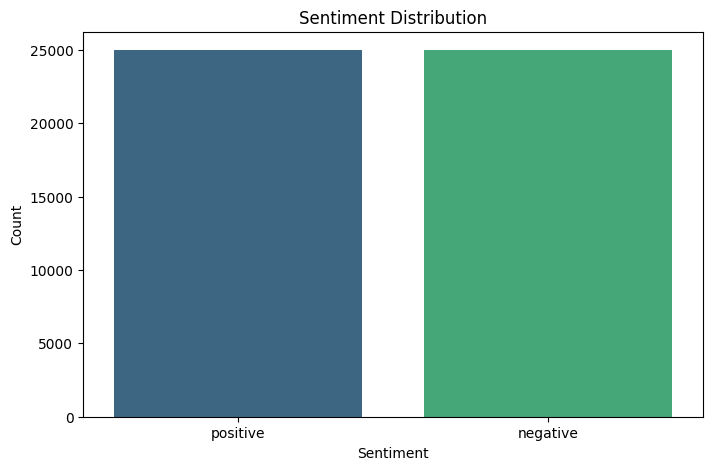

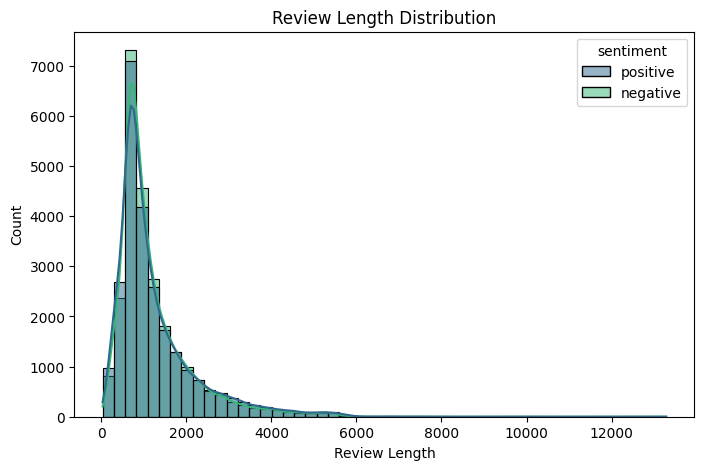

In [3]:
def perform_eda():
    print("Connecting to database for EDA...")
    conn = sqlite3.connect("IMDB_Dataset.db")
    query = "SELECT * FROM IMDB_Dataset"
    data = pd.read_sql_query(query, conn)

    # Basic statistics
    print("Basic statistics:")
    print(data['sentiment'].value_counts())

    # Average review length per sentiment
    data['review_length'] = data['review_text'].apply(len)
    avg_length = data.groupby('sentiment')['review_length'].mean()
    print("\nAverage review length:")
    print(avg_length)

    # Plot sentiment distribution
    plt.figure(figsize=(8, 5))
    sns.countplot(x='sentiment', data=data, palette='viridis')
    plt.title('Sentiment Distribution')
    plt.xlabel('Sentiment')
    plt.ylabel('Count')
    plt.show()

    # Plot review length distribution
    plt.figure(figsize=(8, 5))
    sns.histplot(data, x='review_length', hue='sentiment', bins=50, kde=True, palette='viridis')
    plt.title('Review Length Distribution')
    plt.xlabel('Review Length')
    plt.ylabel('Count')
    plt.show()

    conn.close()
perform_eda()

## Step 5: Train a Classification Model

In [4]:
def train_model():
    print("Connecting to database for model training...")
    conn = sqlite3.connect("IMDB_Dataset.db")
    query = "SELECT * FROM IMDB_Dataset"
    data = pd.read_sql_query(query, conn)

    # Prepare data
    X = data['review_text']
    y = data['sentiment']

    # Split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Vectorize text using TF-IDF
    print("Vectorizing text data...")
    vectorizer = TfidfVectorizer(max_features=5000)
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)

    # Train logistic regression model
    print("Training logistic regression model...")
    model = LogisticRegression()
    model.fit(X_train_tfidf, y_train)

    # Evaluate model
    print("Evaluating model...")
    y_pred = model.predict(X_test_tfidf)
    print(classification_report(y_test, y_pred))

    # Save the model and vectorizer
    print("Saving model and vectorizer...")
    with open("model.pkl", "wb") as model_file:
        pickle.dump(model, model_file)
    with open("vectorizer.pkl", "wb") as vectorizer_file:
        pickle.dump(vectorizer, vectorizer_file)

    conn.close()
train_model()

Connecting to database for model training...
Vectorizing text data...
Training logistic regression model...
Evaluating model...
              precision    recall  f1-score   support

    negative       0.90      0.88      0.89      4961
    positive       0.88      0.91      0.90      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

Saving model and vectorizer...
